In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os.path
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from ARIMA_PermEnt import weighted_perm_entropy, min_weighted_perm_entropy
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
# from pyentrp import entropy as ent
import math
# import plotly.graph_objs as go
import time
plt.style.use('seaborn-whitegrid')
plt.rcParams['text.usetex'] = True
%matplotlib inline  

In [25]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [26]:
#most significant autocorrelation lag
def max_lag_autocorr(ts,lags=7):
    ac1 = 0
    max_lag = 0
    for i in range(1,lags+1):
        ac = np.abs(ts.autocorr(lag=i))
        if ac > ac1:
            ac1 = ac
            max_lag = i
    return max_lag , ac1

In [27]:

def sample_entropy_autocorr_window(df, window=52, n_samples = 100, p_sample = [0.8, 0.5, 0.1]):
    states = df.columns[2:]
    results = []
    for state in states:
        print(state)
        ts = df[state]
        first_idx = ts.first_valid_index()
        last_idx = ts.last_valid_index()
        ts = ts[first_idx:last_idx]
        if ts.shape[0]<= 0:
            continue
        #discard ts with too many NA
        na_per = ts.dropna().shape[0]/ts.shape[0]
        if na_per<0.2:
            continue
        n = ts.dropna().shape[0]
        if n < window:
            continue
        k = 0
        while k < n_samples:
            k+=1
            start = np.random.randint(n-window)
            ts_window = ts[start:start+window]
            #discard ts with too many NA
            na_per = ts_window.dropna().shape[0]/ts_window.shape[0]
            if na_per<0.75:
                continue
            entropy, order = min_weighted_perm_entropy(ts_window, min_order=2, max_order=10, normalize=True)
            max_lag, autocorr =  max_lag_autocorr(ts_window,lags=15)
            var = np.var(ts_window)
            mean = np.mean(ts_window)
            for p in p_sample:
                ts_sample = ts_window.apply(lambda x: np.random.binomial(x, p, size = 1)[0] if not np.isnan(x) else None )
                entropy_sample = weighted_perm_entropy(ts_sample, order=order,delay=1, normalize=True)
                autcorr_sample = np.abs(ts_sample.autocorr(lag=max_lag))
                results.append([state,entropy_sample,entropy,entropy_sample/entropy,order,p, autocorr, autcorr_sample, max_lag,var,mean])
#                 print(state, entropy, entropy_sample, order, autocorr, autcorr_sample, max_lag)
    
    df = pd.DataFrame.from_records(results,columns=['state','entropy_sample','entropy','ratio','order','sample_rate','autocorr','autcorr_sample','max_lag','var','mean']).dropna()
    print('finished')
    return df



In [28]:
def plot_entropy(df_results,p_sample, label):
    df1 = df_results[df_results.disease==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['entropy'][p_sample[0]]]+[df['entropy_sample'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=2)
    y_q1 = [df_q1['entropy'][p_sample[0]]]+[df_q1['entropy_sample'][p] for p in p_sample]
    y_q3 = [df_q3['entropy'][p_sample[0]]]+[df_q3['entropy_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)
    

def plot_autocorr(df_results, p_sample, label):
    df1 = df_results[df_results.disease==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['autocorr'][p_sample[0]]]+[df['autcorr_sample'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=2)
    y_q1 = [df_q1['autocorr'][p_sample[0]]]+[df_q1['autcorr_sample'][p] for p in p_sample]
    y_q3 = [df_q3['autocorr'][p_sample[0]]]+[df_q3['autcorr_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 

    
    
def plot_entropy_ratio(df_results, p_sample, label):
    df1 = df_results[df_results.disease==label]
    df1['ratio'] =  df1['entropy_sample']/df1['entropy']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.plot(x,y,label=label,linewidth=2)
    y_q1 = [1.0]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.0]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)    
    
    
def plot_autocorr_ratio(df_results, p_sample, label):
    df1 = df_results[df_results.disease==label]
    df1['ratio'] =  df1['autcorr_sample']/df1['autocorr']
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [1.]+[df['ratio'][p] for p in p_sample]
    plt.plot(x,y,label=label, linewidth=2)
    y_q1 = [1.]+[df_q1['ratio'][p] for p in p_sample]
    y_q3 = [1.]+[df_q3['ratio'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    
def plot_autocorr_theoretical(df_results, p_sample, label, color):
    df1 = df_results[df_results.disease==label]
    df1['x_norm'] *= df1['autocorr']
    df = df1.groupby(['sample_rate']).mean()
#     df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q1 = df1.groupby(['sample_rate']).mean()+df1.groupby(['sample_rate']).std()
#     df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    df_q3 = df1.groupby(['sample_rate']).mean()-df1.groupby(['sample_rate']).std()
    x = [1.] + p_sample
#     x = 1.-np.array(x)
    y = [df['autocorr'][p_sample[0]]]+[df['autcorr_sample'][p] for p in p_sample]
    y_t = [df['autocorr'][p_sample[0]]]+[df['x_norm'][p] for p in p_sample]
    
    y_q1 = [df_q1['autocorr'][p_sample[0]]]+[df_q1['x_norm'][p] for p in p_sample]
    y_q3 = [df_q3['autocorr'][p_sample[0]]]+[df_q3['x_norm'][p] for p in p_sample]
    
    plt.fill_between(x, y_q1, y_q3, alpha=0.1)  
    plt.plot(x,y_t,linewidth=2,alpha=1, c=color)
    plt.plot(x,y,'o', markersize=8, alpha=1, c=color, label=label)
    


In [30]:
def compute_predictability(window= 52, n_samples=100, p_sample = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05, 0.01]):
    hepatitis_df = pd.read_csv("Data/epidemics/HEPATITIS_A_Cases_1966-2014_20160707103116.csv",skiprows=2, na_values="-")
    influenza_df = pd.read_csv("Data/epidemics/INFLUENZA_Cases_1919-1951_20151014132002.csv",skiprows=2, na_values="-")
    measles_df = pd.read_csv("Data/epidemics/MEASLES_Cases_1909-2001_20150923120449.csv", na_values="-")
    chlamydia_df = pd.read_csv("Data/epidemics/CHLAMYDIA_Cases_2006-2014_20160707103149.csv",skiprows=2, na_values="-")
    polio_df = pd.read_csv("Data/epidemics/POLIOMYELITIS_Cases_1921-1971_20150923114821.csv",skiprows=2, na_values="-")
    gonorrhea_df = pd.read_csv("Data/epidemics/GONORRHEA_Cases_1972-2014_20160707103202.csv",skiprows=2, na_values="-")
    mumps_df = pd.read_csv("Data/epidemics/MUMPS_Cases_1967-2014_20160707103045.csv",skiprows=2, na_values="-")
    whooping_df = pd.read_csv("Data/epidemics/WHOOPING_COUGH_[PERTUSSIS]_Cases_1909-2014_20160607104756.csv",skiprows=2, na_values="-")
    
    
    df_results = sample_entropy_autocorr_window(hepatitis_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df_results['disease'] = 'Hepatitis'
    df = sample_entropy_autocorr_window(influenza_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Influenza'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(measles_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Measles'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(chlamydia_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Chlamydia'
    df_results =  df_results.append(df, ignore_index=True)
    results5 = sample_entropy_autocorr_window(polio_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Polio'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(gonorrhea_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Gonorrhea'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(mumps_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Mumps'
    df_results =  df_results.append(df, ignore_index=True)
    df = sample_entropy_autocorr_window(whooping_df, window=window, n_samples=n_samples, p_sample = p_sample)
    df['disease'] = 'Whooping'
    df_results =  df_results.append(df, ignore_index=True)
    
    return df_results


# Main

In [ ]:
p_sample = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
n_samples = 100

data_file = 'Data/epidemics/results_W52.csv'
if os.path.exists(data_file):
    df_results = pd.read_csv(data_file)
else:
    #run once to compute and save entropy on data
    #Takes several minutes
    df_results = compute_predictability(window= 52, n_samples=n_samples,  p_sample = p_sample)
    df_results.to_csv('Data/epidemics/results_W52.csv', index=False)

diseases = df_results.disease.unique()

ALABAMA


/Users/aabeliuk/Dropbox/My Mac (Andress-MacBook-Air.local)/Documents/Predictability/ARIMA_PermEnt.py:70: RuntimeWarning: invalid value encountered in true_divide
  weights = weights/np.sum(weights) # normalization
/Users/aabeliuk/Dropbox/My Mac (Andress-MacBook-Air.local)/Documents/Predictability/ARIMA_PermEnt.py:137: RuntimeWarning: divide by zero encountered in log2
  pe = -np.multiply(p, np.log2(p)).sum()
/Users/aabeliuk/Dropbox/My Mac (Andress-MacBook-Air.local)/Documents/Predictability/ARIMA_PermEnt.py:137: RuntimeWarning: invalid value encountered in multiply
  pe = -np.multiply(p, np.log2(p)).sum()


ALASKA
AMERICAN SAMOA
ARIZONA
ARKANSAS
CALIFORNIA
COLORADO
CONNECTICUT
DELAWARE
DISTRICT OF COLUMBIA
FLORIDA


In [8]:
#normalize results
df_results['ratio'] =  df_results['autcorr_sample']/df_results['autocorr']
df_results['p2var'] = df_results['sample_rate']*df_results['sample_rate']*df_results['var']
df_results['x_norm'] = df_results['p2var']/(df_results['p2var']+df_results['sample_rate']*(1.-df_results['sample_rate'])*df_results['mean'])
df_results['x_norm'] *= df_results['autcorr_sample']
df_results.head()

,state,entropy_sample,entropy,ratio,order,sample_rate,autocorr,autcorr_sample,max_lag,var,mean,disease,p2var,x_norm
0,ALABAMA,0.926858,0.912384,1.013029,5,0.9,0.324765,0.328996,15,23.221808,5.416582,Hepatitis,18.809664,0.320685
1,ALABAMA,0.922273,0.912384,0.918883,5,0.8,0.324765,0.298421,15,23.221808,5.416582,Hepatitis,14.861957,0.281978
2,ALABAMA,0.910226,0.912384,1.138286,5,0.7,0.324765,0.369675,15,23.221808,5.416582,Hepatitis,11.378686,0.336079
3,ALABAMA,0.908163,0.912384,0.713473,5,0.6,0.324765,0.231711,15,23.221808,5.416582,Hepatitis,8.359851,0.200528
4,ALABAMA,0.910209,0.912384,0.507929,5,0.5,0.324765,0.164957,15,23.221808,5.416582,Hepatitis,5.805452,0.133758


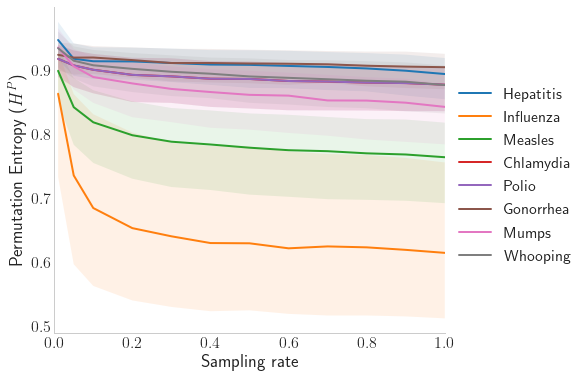

In [24]:
#plot entropy
fig, ax = plt.subplots(figsize=(7, 6))
for disease in diseases:
    plot_entropy(df_results, p_sample, label=disease)

plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Sampling rate')
plt.ylabel(r'Permutation Entropy ($H^P$)')
plt.savefig('Figures/epidemic_entropy_W52.pdf', bbox_inches='tight')

<ipython-input-19-cf34de2f2163>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ratio'] =  df1['entropy_sample']/df1['entropy']


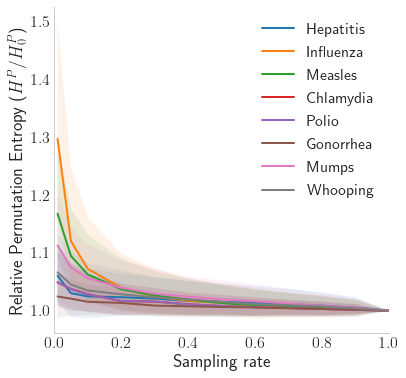

In [20]:
#plot entropy Ratio
fig, ax = plt.subplots(figsize=(6, 6))
for disease in diseases:
    plot_entropy_ratio(df_results, p_sample, label=disease)

# plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.legend( ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Sampling rate')
plt.ylabel(r'Relative Permutation Entropy ($H^P/H^P_0$)')
plt.savefig('Figures/epidemic_entropy_ratio_W52.pdf', bbox_inches='tight')

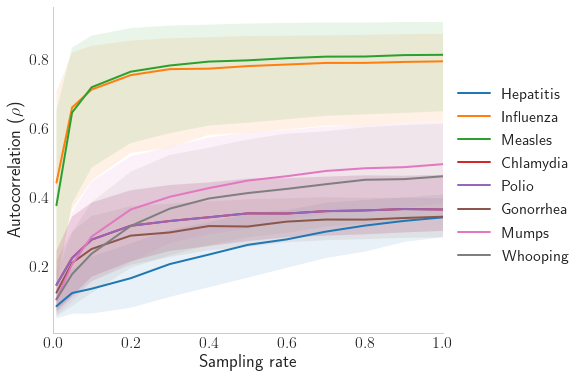

In [21]:
#plot autocorrelation 
fig, ax = plt.subplots(figsize=(7, 6))
for disease in diseases:
    plot_autocorr(df_results, p_sample, label=disease)
    

plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel(r'Autocorrelation ($\rho$)')
plt.savefig('Figures/epidemic_autocorr_W52.pdf', bbox_inches='tight')


<ipython-input-19-cf34de2f2163>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['x_norm'] *= df1['autocorr']


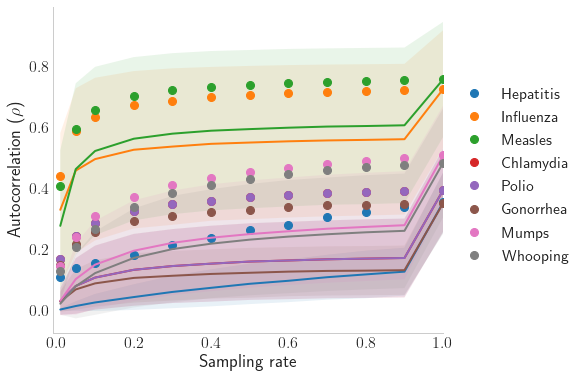

In [22]:
#plot theoretical autocorrelation 
fig, ax = plt.subplots(figsize=(7, 6))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
i=0
for disease in diseases:
    plot_autocorr_theoretical(df_results, p_sample, label=disease, color=colors[i])
    i+=1

plt.legend( bbox_to_anchor=(1, 0.8), ncol=1)

plt.xlim(-0.01,1.)

ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel(r'Autocorrelation ($\rho$)')
plt.savefig('Figures/epidemic_theo_autocorr_W52.pdf', bbox_inches='tight')


<ipython-input-19-cf34de2f2163>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ratio'] =  df1['autcorr_sample']/df1['autocorr']


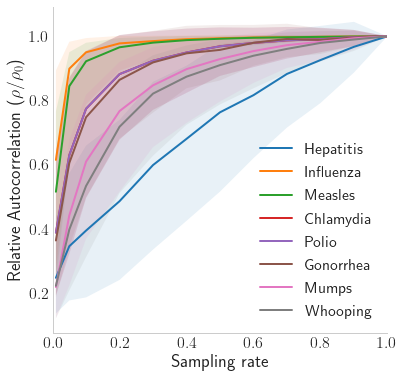

In [23]:
#plot autocorrelation  ratio
fig, ax = plt.subplots(figsize=(6, 6))
for disease in diseases:
    plot_autocorr_ratio(df_results, p_sample, label=disease)

# plt.legend(bbox_to_anchor=(1, 0.8), ncol=1)
plt.legend( ncol=1)
plt.xlim(0,1.)

ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel(r'Relative Autocorrelation ($\rho/\rho_0$)')
plt.savefig('Figures/epidemic_autocorr_ratio_W52.pdf', bbox_inches='tight')

In [ ]:
df = df_results.groupby(['state','disease','sample_rate']).mean()
df = df.reset_index()
# sns.lmplot(x="x_norm", y="ratio", scatter_kws={"s": 1,'alpha':0.05}, data=df)
fig, ax = plt.subplots(figsize=(6, 6))


for d in df.disease.unique():
    plot_df = df[df.disease==d]
    plt.plot(plot_df.x_norm, plot_df.autcorr_sample, '.', markersize=8, alpha=0.5, label = d )

plt.plot([0,1],[0,1], color='grey', alpha=0.8)
plt.legend(ncol=1,markerscale=2)
ax.grid(color='grey', linestyle='--', linewidth=0.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel(r'Theoretical Autocorrelation $\frac{\rho_0 p^2 \mathrm{Var}(X)}{p^2 + p(1-p)E[X]}$')
plt.ylabel(r'Empirical Autocorrelation ($\rho$)')
plt.savefig('Figures/disease_theoretical.pdf', bbox_inches='tight')

# external signal

In [ ]:
def week_to_date(x): 
    d =  str(x['YEAR'])+'-W'+ str(x['WEEK'])
    r = datetime.datetime.strptime(d + '-0', "%Y-W%W-%w")
    return r

In [ ]:
influenza_df = pd.read_csv("Data/epidemics/ILINet.csv",skiprows=1, na_values="X")
influenza_df['date'] = influenza_df.apply(week_to_date, axis=1)
influenza_df['date']  = pd.to_datetime(influenza_df['date']).apply(lambda x: x.strftime('%Y-%m-%d'))
influenza_df = influenza_df.pivot_table(index = ['date'], columns=['REGION'], values=['TOTAL PATIENTS'])['TOTAL PATIENTS']
influenza_df.index = pd.to_datetime(influenza_df.index)
influenza_df.head()

google_df = pd.read_csv("Data/epidemics/google_flu.csv")
google_df['date']  = pd.to_datetime(google_df['date']).apply(lambda x: x.strftime('%Y-%m-%d'))
google_df.set_index('date', inplace=True)
google_df.index = pd.to_datetime(google_df.index)

start_day = max(influenza_df.index.min(),google_df.index.min())
end_date = min(influenza_df.index.max(),google_df.index.max())
day_range = pd.date_range(start_day, end_date, freq='W')
influenza_df = influenza_df[influenza_df.index>=start_day]
influenza_df = influenza_df[influenza_df.index<=end_date]
google_df = google_df[google_df.index>=start_day]
google_df = google_df[google_df.index<=end_date]


google_df.head()

In [ ]:
def sample_ext_corr_window(influenza_df, google_df, window=52, p_sample = [0.8, 0.5, 0.1]):
    n_samples = 100
    states = influenza_df.columns
    start_day = max(influenza_df.index.min(),google_df.index.min())
    end_date = min(influenza_df.index.max(),google_df.index.max())
    day_range = pd.date_range(start_day, end_date, freq='W')
    p_ex = 0.5
    results = []
    for state in states:
        if not state in google_df.columns:
            continue
        print(state)
        
        ts = influenza_df[state]
        ts_ex = google_df[state]

        ts = ts.reindex(day_range,fill_value=None)
        ts_ex = ts_ex.reindex(day_range,fill_value=None)
        n = ts.shape[0]
        
        k = 0
        while k < n_samples:
            k+=1
            start = np.random.randint(n-window)
            ts_window = ts[start:start+window]
            ts_window_ex = ts_ex[start:start+window]

            corr = np.abs(ts_window.corr(ts_window_ex))
            cov = np.abs(ts_window.cov(ts_window_ex))
            var = np.var(ts_window)
            mean = np.mean(ts_window)
            for p in p_sample:
                for p_ex in p_sample:
                    ts_sample = ts_window.apply(lambda x: np.random.binomial(x, p, size = 1)[0] if not np.isnan(x) else None )
                    ts_window_ex_sample = ts_window_ex.apply(lambda x: np.random.binomial(x, p_ex, size = 1)[0] if not np.isnan(x) else None )
                    cov_sample = np.abs(ts_sample.cov(ts_window_ex_sample))
                    corr_sample = np.abs(ts_sample.corr(ts_window_ex_sample))
                    results.append([state,p, p_ex, corr,corr_sample,cov, cov_sample,var,mean])
    #                 print(state, entropy, entropy_sample, order, autocorr, autcorr_sample, max_lag)
    
    df = pd.DataFrame.from_records(results,columns=['state','sample_rate','sample_rate_ext','corr','corr_sample','cov','cov_sample','var','mean']).dropna()
    print('finished')
    return df



In [ ]:
p_sample = [1.,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05,0.01]
df_results_ex = sample_ext_corr_window(influenza_df, google_df, window=52, p_sample = p_sample )
df_results_ex.head()

In [ ]:
def plot_cov_ext(df_results, p_sample):
#     df1 = df_results[df_results.state==label]
    df1 = df_results
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
#     x = 1.-np.array(x)
    y = [df['cov_sample'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2)
    y_q1 = [df_q1['cov_sample'][p] for p in p_sample]
    y_q3 = [df_q3['cov_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 

def plot_cov_ext_states(df_results, p_sample,label):
    df1 = df_results[df_results.state==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
#     x = 1.-np.array(x)
    y = [df['cov_sample'][p] for p in p_sample]
    plt.plot(x,y, linewidth=1, label=label)
    y_q1 = [df_q1['cov_sample'][p] for p in p_sample]
    y_q3 = [df_q3['cov_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.05) 
    
    return x,y
    
def plot_corr_ext(df_results, p_sample):
#     df1 = df_results[df_results.state==label]
    df1 = df_results
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x =  p_sample
#     x = 1.-np.array(x)
    y = [df['corr_sample'][p] for p in p_sample]
    plt.plot(x,y, linewidth=2)
    y_q1 = [df_q1['corr_sample'][p] for p in p_sample]
    y_q3 = [df_q3['corr_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.1) 
    
    return x,y

def plot_corr_ext_states(df_results, p_sample,label):
    df1 = df_results[df_results.state==label]
    df = df1.groupby(['sample_rate']).median()
    df_q1 = df1.groupby(['sample_rate']).quantile(0.25)
    df_q3 = df1.groupby(['sample_rate']).quantile(0.75)
    x = p_sample
#     x = 1.-np.array(x)
    y = [df['corr_sample'][p] for p in p_sample]
    plt.plot(x,y, linewidth=1, label=label)
    y_q1 = [df_q1['corr_sample'][p] for p in p_sample]
    y_q3 = [df_q3['corr_sample'][p] for p in p_sample]
    plt.fill_between(x, y_q1, y_q3, alpha=0.05) 
    
    return x,y

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
yy=[]
xx=[]
df = df_results_ex[df_results_ex['sample_rate_ext']==1.]
for state in df_results_ex.state.unique():
    x,y = plot_cov_ext_states(df, p_sample,state)
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

# plt.legend( bbox_to_anchor=(1, 0.8), ncol=4)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel(r'Covariance ($\mathrm{Cov}(Y,S)$)')
plt.savefig('Figures/epidemic_cov_ext_W52.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
yy=[]
xx=[]
df = df_results_ex[df_results_ex['sample_rate_ext']==1.]
for state in df_results_ex.state.unique():
    x,y = plot_corr_ext_states(df, p_sample,state)
    yy.append(y)
    xx.append(x)
    

#Average of all
y = np.mean(np.array(yy), axis=0)
# y_q1 = np.quantile(np.array(yy), q=0.25, axis=0)
# y_q3 = np.quantile(np.array(yy), q=0.75, axis=0)
plt.plot(x,y,label='Average', linewidth=6, color='black')
# plt.fill_between(x, y_q1, y_q3, alpha=0.1, color='black')

# plt.legend( bbox_to_anchor=(1, 0.8), ncol=4)
ax.grid(color='grey', linestyle='--', linewidth=.25, alpha=0.5)
#removing top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xlabel('Sampling rate')
plt.ylabel("Pearson's correlation")
plt.savefig('Figures/epidemic_corr_ext_W52.pdf', bbox_inches='tight')